In [1]:
#import audio
import librosa

In [2]:
import random
import numpy as np

# Audio augmentations

## Chunk extraction

### Helper function: `wraparound_extract()`

In [3]:
def wraparound_extract(original, begin, length):
    '''
    Extracts elements from numpy.array in a "wraparound" fashion
    
    Extracts a certain number of elements from 
    a numpy.array starting at a certain position.
    If the chosen position and length go
    past the end of the array, the extraction
    "wraps around" to the beginning of the numpy.array
    as many times as necessary. For instance:
    
    wraparound_extract(
        original = [0, 5, 10],
        begin = 1, 
        length = 7) -> [5, 10, 0, 5, 10, 0, 5]
    
    Args:
        original (np.array): the original array 
        begin (int): beginning position to extract
        length (int): number of elements to extract
    '''

    # Get `head`: the array after the beginning position
    assert(type(original) == np.ndarray)
    len_original = original.shape[0]
    begin = begin % len_original
    head = original[begin:]
    len_head = head.shape[0]

    # Number of elements we require for full wrap-around
    wrap_needed = length - len_head

    # Generate the desired list, wrapped if necessary
    if wrap_needed > 0:
        repeats = np.tile(original, int(wrap_needed/len_original))
        tail = np.array(original[ : (wrap_needed % len_original)])
        desired_list = np.concatenate((head, repeats, tail))
    else:
        desired_list = original[begin:begin+length]
    
    #print(desired_list)
    return desired_list

In [4]:
import numpy.testing as npt

# test zero beginning, not getting to end of original array
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 0, length = 1), np.array([0]))

# test zero beginning, not getting to end of original array
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 0, length = 2), np.array([0, 1]))

# test zero beginning, not wrapping
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 0, length = 2), np.array([0, 1]))

# test zero beginning, wrapping around
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 0, length = 3), np.array([0, 1, 0]))

# test nonzero beginning, not wrapping
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 1, length = 1), np.array([1]))

# test nonzero beginning, wrapping around
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 1, length = 3), np.array([1, 0, 1]))

# test multiwrap
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 1, length = 10), np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]))

# test wrapping around beginning
npt.assert_array_equal(wraparound_extract(original = np.array([0, 1]), begin = 5, length = 3), np.array([1, 0, 1]))



### Main function: `get_chunk()`

In [5]:
def get_chunk(
    samples, 
    sample_rate,
    start_position = None, # randomize start position
    duration = 5, # 5 seconds
    duration_jitter = 0.5, #jitter duration +- 0.5s
    chance_random_skip = 0.3 #randomly skip 30% of the time
):
    '''
    Extracts chunk of audio with some augmentation
    
    Extracts samples of audio from a master list
    of samples. 
    
    Available data augmentation options include:
        - selecting a position to start extracting from
          or allowing function to randomly choose start
        - selecting duration of chunk and allowing
          for random jitter of duration
        - randomly skipping some number of samples from
          0 to the length of the chunk
    
    If the chunk to be extracted reaches the end of the
    samples, the chunk will "wrap around" and start
    reading from the beginning of the samples.
    
    Args:
        samples (numpy.array): audio samples loaded
            by librosa.load or audio.load
        sample_rate (int or float): sample rate of `samples`
        start_position (int): position in the file to start
            extracting samples from. If None, the start position 
            is chosen randomly
        duration (float): desired duration, in seconds, 
            of chunk to extract
        duration_jitter (float): if this value is not 0,
            the duration of the chunk extracted will 
            be randomly selected from the range 
            (duration - duration_jitter, duration + duration_jitter)
        chance_random_skip (float between 0 and 1):
            percent chance of random skipping. In a random skip,
            a position within the chunk will be randomly
            selected, and from that position in the 
            audio file, a random number of samples will 
            be skipped. The number of samples skipped is between
            0 and the number of samples in the entire chunk
    
    Returns:
        samples
    '''
    
    # Get a random start position
    num_samples = len(samples)
    if not start_position:
        start_position = random.randint(0, num_samples)

    # Convert seconds to samples
    seconds_to_extract = duration + random.uniform(-duration_jitter, duration_jitter)
    samples_to_extract = int(seconds_to_extract * sample_rate)
    
    # Get chunks with skip in the middle with probability = chance_random_skip
    if random.random() < chance_random_skip:
        position_to_skip = random.randint(0, samples_to_extract)
        amount_to_skip = random.randint(0, samples_to_extract)

        chunk_1_start = start_position
        chunk_1_end = chunk_1_start + position_to_skip
        chunk_2_start = chunk_1_end + amount_to_skip
        chunk_2_end = chunk_1_start + (samples_to_extract - position_to_skip)
        
        chunk_1 = wraparound_extract(samples, chunk_1_start, chunk_1_end)
        chunk_2 = wraparound_extract(samples, chunk_2_start, chunk_2_end)
        chunk = np.concatenate((chunk_1, chunk_2))
    
    # Otherwise get contiguous chunk
    else:
        chunk = wraparound_extract(samples, start_position, samples_to_extract) 
        
    
    return chunk
    
samples, sr = librosa.load('../tests/silence_10s.mp3')
get_chunk(samples = samples, sample_rate = sr)

array([-7.5343974e-06, -5.7295296e-07,  1.6479304e-05, ...,
        1.9007699e-05, -2.9289282e-05,  1.8814750e-05], dtype=float32)

### TODO: tests for `get_chunk()`

## Cyclic shift

In [6]:
def cyclic_shift(array, split_point = None):
    '''
    Shift array cyclicly by a random amount
    
    Shift array cyclicly by a random amount. Equivalent to
    splitting array into two parts at a random element, then
    switching the order of the parts.
    
    Args: 
        array (np.array): 1D-array to be split
        split_point (float): percentage from (0, 1) describing
            where in array to split -- for testing purposes.
            For stochastic splitting, leave as None.
    
    Returns:
        shifted_array: shifted array
    '''
    
    assert(type(array) == np.ndarray)
    length = array.shape[0]
    
    # Stochastic split point, or split point by floor of split_point * length of array
    if not split_point: split_point = random.randint(0, length)
    else: split_point = int(split_point * length)
    
    return np.concatenate((array[split_point:], array[:split_point]))

In [7]:
# Test random splitting
random.seed(100)
npt.assert_array_equal(cyclic_shift(np.array((0, 1, 2, 3, 4, 5, 6, 7))), np.array([2, 3, 4, 5, 6, 7, 0, 1]))

# Test deterministic splitting
npt.assert_array_equal(cyclic_shift(np.array([0, 1, 2]), split_point=0.5), np.array([1, 2, 0]))

# Test deterministic splitting
npt.assert_array_equal(cyclic_shift(np.array([0, 1, 2, 3]), split_point=0.5), np.array([2, 3, 0, 1]))

## Divided-samples augmentations: time & freq

### Helper function to divide samples randomly: `divide_samples()`

In [8]:
def divide_samples(
    samples,
    sample_rate,
    low_duration = 0.5,
    high_duration = 5
):
    '''
    Divide audio samples into random-sized segments
    
    Divide audio samples into random-sized segments
    between the desired durations. The number
    of segments is not deterministic.
    
    Args:
        samples (np.ndarray): 1d array of samples
        sample_rate (int or float): sample rate of samples
        low_duration (float): minimum duration
            in seconds of any segment
        high_duration (float): maximum duration
            in seconds of any segment
    
    Returns:
        segments, list of sample lists
    '''
    
    min_chunk = int(low_duration * sample_rate)
    max_chunk = int(high_duration * sample_rate)
    
    samples_to_take = samples.copy()
    
    segments = []
    
    while samples_to_take.shape[0]:
        seg_size = random.randint(min_chunk, max_chunk)
        segment, samples_to_take = np.split(samples_to_take, [seg_size])
        segments.append(segment)
    
    return segments
    

In [9]:
# Test chunk division at set amount
array0 = np.array([0, 0, 0])
array1 = np.array([1, 1, 1])
array2 = np.array([2])
all_arrays = (array0, array1, array2)
cat_arrays = np.concatenate(all_arrays)
results = divide_samples(cat_arrays, sample_rate=1, low_duration=3, high_duration=3)
for idx, result in enumerate(results):
    npt.assert_array_equal(result, all_arrays[idx])
    
# Test random chunk division
random.seed(333)
# Predetermined results with random.seed(333)
predetermined = [np.array([0, 1, 2, 3, 4, 5, 6, 7]), np.array([8, 9])]
results = divide_samples(np.array(range(10)), sample_rate=1, low_duration=0, high_duration=10)
for idx, result in enumerate(results):
    npt.assert_array_equal(result, predetermined[idx])

### Helper function to concatenate divisions: `combine_samples()`

In [10]:
def combine_samples(divided):
    '''
    Recombine divided sample arrays
    
    Combine divided sample arrays back into a 
    single array, perhaps after each division
    has been modified by pitch shifting, time stretching, etc.
    
    Args:
        divided (list of np.ndarrays): list of sample arrays
            divided by divide_samples()
    
    Returns:
        sample arrays concatenated back into a single array
    '''
    
    return np.concatenate(divided)

In [11]:
# Test that divided samples can be recombined successfully
samples, sr = librosa.load('../tests/silence_10s.mp3')
divided = divide_samples(samples, sample_rate=sr, low_duration=0.5, high_duration=4)
npt.assert_array_equal(combine_samples(divided), samples)

### Time stretch the divisions: `time_stretch_divisions()`

In [12]:
def time_stretch_divisions(
    divisions,
    chance_per_division = 0.50,
    mean_stretch = 1,
    sd_stretch = 0.05
):
    '''
    Time stretch divisions
    
    Given a list of np.ndarrays, each np.ndarray representing
    audio samples, time stretch each array with some probability. 
    
    Args"
        divisions (list of np.ndarrays): list of np.ndarrays
            where each element of the list is samples from
            an audio file. A list of divisions can be generated 
            with helper functions in this module
        chance_per_division (float between 0 and 1): for
            each division, the chance it will be time-stretched
        mean_stretch (float): the mean stretch multiplier.
            == 1 is no stretch; > 1 is sped up, < 1 is slowed down
        sd_stretch (float > 0): the sd of the stretch 
            distribution. 
    
    Returns:
        stretched_divisions, time-stretched divisions
    '''
    stretched_divisions = []
    
    for d in divisions:
        if random.random() < chance_per_division:
            stretch_factor = np.random.normal(
                loc = mean_stretch,
                scale = sd_stretch)
            stretched_d = librosa.effects.time_stretch(y = d, rate = stretch_factor)
            stretched_divisions.append(stretched_d)
        else:
            stretched_divisions.append(d)
    
    return stretched_divisions

In [13]:
# Predetermined results with random.seed(333)
#predetermined = [np.array([0., 0.1, -0.1, 0.2, -0.2, 0.3, -0.3, 7]), np.array([8, 9])]
random.seed(3)
divs = divide_samples(np.linspace(0, 1, 10), sample_rate=1, low_duration=0, high_duration=10)
np.random.seed(111)
results = time_stretch_divisions(divs)

# predetermined results for random.seed == 3 and np.random.seed == 111
# np.random.seed must be set because randomness in time_stretch_divisions
# comes from np.random.normal
predetermined = [
    np.array([0.        , 0.11111111, 0.22222222]),
    np.array([0.27306482, 0.36267295, 0.45205913, 0.54126718,
           0.63025186, 0.71660051, 0.80273002])
]

for idx, result in enumerate(results):
    npt.assert_array_almost_equal(result, predetermined[idx])

### Frequency shift the divisions: `pitch_shift_divisions()`

In [14]:
def pitch_shift_divisions(
    divisions,
    sample_rate,
    chance_per_division = 0.40,
    mean_shift = 0,
    sd_shift = 0.25
):
    '''
    Time stretch divisions
    
    Given a list of np.ndarrays, each np.ndarray representing
    audio samples, pitch-shift each array with some probability. 
    The mean_shift and sd_shift should be given in "fractional
    half-steps," e.g. 0.25 = 1/4th of a half-step = 25 cents.
    
    Args:
        divisions (list of np.ndarrays): list of np.ndarrays
            where each element of the list is samples from
            an audio file. A list of divisions can be generated 
            with helper functions in this module
        sample_rate (int or float): sample rate of all divisions
        chance_per_division (float between 0 and 1): for
            each division, the chance it will be time-stretched
        mean_shift (float): the mean pitch shift in (fractional) half-steps
            == 0 is no shift; > 0 is shift up; < 1 is shift down
        sd_shift (float > 0): the sd of the shift 
            distribution in cents
    
    Returns:
        shifted_divisions, pitch-shifted divisions
    '''
    shifted_divisions = []
    
    for d in divisions:
        if random.random() < chance_per_division:
            shift_factor = np.random.normal(
                loc = mean_shift,
                scale = sd_shift)
            shifted_d = librosa.effects.pitch_shift(
                y = d,
                sr = sample_rate,
                n_steps = shift_factor)
            shifted_divisions.append(shifted_d)
        else:
            shifted_divisions.append(d)
    
    return shifted_divisions

In [15]:
divs = divide_samples(
    samples = samples,
    sample_rate = sr,
    low_duration = 0.5,
    high_duration = 4)
print(divs)
print()
print(pitch_shift_divisions(divs, sample_rate = sr))

[array([-3.1739323e-06, -1.4155360e-05, -8.0013604e-07, ...,
        1.8794424e-06,  7.1658078e-06, -4.9842856e-06], dtype=float32), array([ 3.5037613e-06, -3.3692386e-06,  6.0074067e-06, ...,
        3.2044059e-05, -1.1334268e-05,  2.3847722e-05], dtype=float32), array([-5.5799287e-06, -9.8192986e-06,  2.4171062e-05, ...,
        1.2083449e-05,  4.3980071e-06,  5.0061476e-06], dtype=float32), array([ 1.5683046e-06,  3.5010305e-06, -1.2555935e-05, ...,
        6.1320316e-06, -1.4582495e-06, -1.5945519e-05], dtype=float32), array([ 2.0357647e-05, -5.1009292e-06,  1.6706794e-05, ...,
        2.3299851e-06, -1.1209999e-06, -1.9890509e-05], dtype=float32)]

[array([-3.7917514e-06, -1.3651467e-05, -1.0827831e-06, ...,
        1.1708037e-05,  7.8524317e-07,  0.0000000e+00], dtype=float32), array([ 3.2972698e-06, -3.0527028e-06,  5.5270198e-06, ...,
        2.5871668e-06,  8.6151454e-07,  0.0000000e+00], dtype=float32), array([-5.5799287e-06, -9.8192986e-06,  2.4171062e-05, ...,
        1.208

## Random audio filtering: `random_filter()`

In [16]:
from scipy.signal import butter, lfilter
def random_filter(
    samples,
    sample_rate,
    percent_chance = 0.20,
    filter_type = None,
    filter_order = None,
    filter_low = None,
    filter_high = None,
    error_check = True
):
    '''
    Randomly filter audio samples
    
    With some probability, apply a filter to `samples`. 
    Some or all of the filter's characteristics can be 
    provided by the user; otherwise, they are
    are randomly selected from the following options:
    
    Type: lowpass, highpass, bandpass, bandstop
    Order: 1-5
    Low cutoff frequency: from 1Hz to (sample_rate/2) - 1 Hz
    High cutoff frequency (bandpass 
        and bandstop filters): from low_freq+1 
        to (sample_rate/2) - 1 Hz
        
    If filter output contains values not between -1.0 and 1.0,
    the original signal is returned to avoid glitchy filters.
    '''
    
    if random.random() < percent_chance:
        
        # Nyquist frequency
        nyq = 0.5 * sample_rate
        
        # Select random filter choices
        if not filter_type: filter_type = random.choice(
            ['lowpass', 'highpass', 'bandpass', 'bandstop'])
        if not filter_order: filter_order = random.randint(1, 5)
        if not filter_low: filter_low = random.randint(1, (nyq - 1))
        if not filter_high:
            if filter_type in ['bandpass', 'bandstop']:
                filter_high = random.randint(filter_low, nyq - 1)
            else:
                filter_high = nyq - 1
        

        # Filter the audio
        low = filter_low / nyq
        high = filter_high / nyq
        b, a = butter(filter_order, [low, high], btype='band')
        filtered = lfilter(b, a, samples)

         # Error check filtered audio
        if error_check:
            if  np.less(filtered, -1, where=~np.isnan(filtered)).any() or \
                np.greater(filtered, 1, where=~np.isnan(filtered)).any():
                return samples
                # For debugging
                #return samples, filtered, [filter_type, filter_order, filter_low, filter_high]
            else:
                return filtered
                # For debugging
                #return filtered, filtered, [filter_type, filter_order, filter_low, filter_high]
        else:
            return filtered
    
    else: return samples
    
    

In [17]:
unfiltered, sample_rate = librosa.load('../tests/1min.wav')

# This filter will produce an invalid output 
# i.e., the array will contain values above 1
filtered_not_checked = random_filter(
    unfiltered, sample_rate, percent_chance=1,
    filter_type = 'highpass',
    filter_order = 5,
    filter_low = 2690,
    filter_high = 11024.0,
    error_check = False
)
assert((filtered_not_checked > 1).any())

# The same filter as above, but with error checking: 
# the error check should flag the invalid content
# in the filtered result and return the original array
filtered_checked = random_filter(
    unfiltered, sample_rate, percent_chance=1,
    filter_type = 'highpass',
    filter_order = 5,
    filter_low = 2690,
    filter_high = 11024.0,
    #error_check = True # Error checking by default
)
assert(~(filtered_checked > 1).any())
assert(filtered_checked is unfiltered)

## Adding audio chunks

### Helper function, fade audio in or out: `fade()`

In [18]:
def fade(array, fade_len, start_amp=1):
    '''
    Fade audio in or out
    
    Args:
        array (np.array): 1d audio array to fade
            in or out
        fade_len (int): the number of samples over which
            the fade should occur; must be smaller than 
            array.shape[0]
        start_amp (int, 1 or 0): whether to start at full 
            volume and fade out (1) or start at
            0 volume and fade in (0)
        
    '''
    
    if not ((start_amp is 0) or (start_amp is 1)):
        raise ValueError('start_amp must be either 0 or 1') from None
    
    pad_len = int(array.shape[0] - fade_len)
    if pad_len < 0:
        raise IndexError('fade_len is longer than the number of samples in array') from None
    
    # Construct fade filter
    #fade_filter = np.linspace(start_amp, int(not start_amp), fade_len)
    # If fade_len is 1 and start_amp is 1, the above code results in 
    # a fade_filter = np.array([1.]), i.e. no fading. The below code
    # ensures that the end amplitude is included
    fade_filter = np.flip(np.linspace(int(not start_amp), start_amp, fade_len))
    
    # Pad filter for array length
    if start_amp == 0: # fade in at start
        fade_filter_padded = np.pad(
            fade_filter,
            (0, pad_len), # pad right side
            constant_values = 1 # with 1s
        )
    else: # start_amp == 1, fade out at end
        fade_filter_padded = np.pad(
            fade_filter,
            (pad_len, 0), # pad left side
            constant_values = 1 # with 1s
        )
    return np.multiply(array, fade_filter_padded)

In [19]:
import pytest
# Assert that fading out doesn't work if fade_len is too long
with pytest.raises(IndexError):
    fade(array = np.array((1, 1, 1, 1, 1)), fade_len=6, start_amp=1)
    
# Assert that can only provide 0 or 1 as start_amp
with pytest.raises(ValueError):
    fade(array = np.array((1, 1, 1)), fade_len=3, start_amp=1.0)
with pytest.raises(ValueError):
    fade(array = np.array((1, 1, 1)), fade_len=3, start_amp=True)
    
# Fade in on exactly correct length array
fade_in = fade(array = np.array((1, 1, 1, 1, 1)), fade_len=5, start_amp=0)
npt.assert_array_equal(fade_in, np.array([0., 0.25, 0.5, 0.75, 1.]))

# Fade out on long array
fade_out = fade(array = np.array((1, 1, 1, 1, 1, 1, 1)), fade_len=5, start_amp=1)
npt.assert_array_equal(fade_out, np.array([1., 1., 1., 0.75, 0.5, 0.25, 0.]))

### Helper function, pairwise sample summer: `sum_samples()`

In [20]:
import math
def sum_samples(
    samples_original,
    samples_new,
    sample_rate,
    wraparound_fill = False,
    fade_out = True
):
    '''
    Sums audio samples and updates labels
    
    Combines audio samples, samples_new, on top
    of samples_original, overlaying samples_new
    so it begins at the same time as samples_original.
    
    Args:
        samples_original (np.array): samples to 
            overlay new samples on
        samples_new (np.array): samples to be
            overlayed on original samples. If shorter
            than samples_original, can either be repeated/
            wrapped around to reach length of
            samples_original, or can be faded out
        sample_rate (int or float): mutual sample rate
            of both samples_original and samples_new
        wraparound_fill (bool): whether or not to 
            fill in short samples_new by wrapping around
        fade_out (bool): whether or not to fade out 
            short samples_new. If wraparound_fill == True,
            this option does not apply.
            
    Returns:
        summed samples
    '''
    
    original_len = samples_original.shape[0]
    new_len = samples_new.shape[0]
    discrepancy = original_len - new_len
    
    # Add new samples to original samples, possibly applying 
    # fade-out, filling, etc.
    if discrepancy > 0: # if new_len shorter than original_len
        # Make up length by repeating/"wrapping around"
        if wraparound_fill:
            samples_to_add = wraparound_extract(
                original = samples_new,
                begin = 0,
                length = original_len)
        
        # Make up length with zero-padding
        else:
            samples_to_add = samples_new.copy()
            if fade_out:
                # Number of samples used in fade should be about 0.5s
                fade_samples = math.ceil(0.1 * sample_rate)
                if fade_samples > new_len: fade_samples = new_len

                # Apply fade
                samples_to_add = fade(
                    array = samples_to_add,
                    fade_len = fade_samples,
                    start_amp = 1,
                )
            
            # Zero pad
            samples_to_add = np.pad(
                samples_to_add,
                (0, discrepancy),
                constant_values = 0
            )
    else:
        samples_to_add = samples_new[:original_len]
        
    return np.add(samples_original, samples_to_add)

In [21]:
# Test fade & wraparound on audio-like numpy arrays
nowrap_nofade = sum_samples(
    samples_original = np.array((1., 1., 500.)),
    samples_new = np.array((10., 11.)),
    sample_rate = 1,
    wraparound_fill = False,
    fade_out = False
)
npt.assert_array_equal(nowrap_nofade, np.array([11., 12.,  500.]))

nowrap_fade = sum_samples(
    samples_original = np.array((1., 1., 1., 500.)),
    samples_new = np.array((10., 10.)),
    sample_rate = 1,
    wraparound_fill = False,
    fade_out = True
)
npt.assert_array_equal(nowrap_fade, np.array([ 11.,   1.,   1., 500.]))

wrap_nofade = sum_samples(
    samples_original = np.array((1., 1., 500.)),
    samples_new = np.array((10., 11.)),
    sample_rate = 1,
    wraparound_fill = True,
    fade_out = False
)
npt.assert_array_equal(wrap_nofade, np.array([11., 12.,  510.]))

# Same behavior as wrap_nofade
wrap_fade = sum_samples(
    samples_original = np.array((1., 1., 500.)),
    samples_new = np.array((10., 11.)),
    sample_rate = 1,
    wraparound_fill = True,
    fade_out = True
)
npt.assert_array_equal(wrap_nofade, np.array([11., 12.,  510.]))


# Test on actual audio without fade or wraparound
samples, sample_rate = librosa.load('../tests/1min.wav')
samples_original = samples[:22050]
samples_new = cyclic_shift(samples_original)[:11025]

summed = sum_samples(
    samples_original = samples_original,
    samples_new = samples_new,
    sample_rate = sample_rate,
    wraparound_fill = False,
    fade_out = False)

true_summed = np.add(samples_original, np.pad(samples_new, (0, 11025), constant_values=0))
npt.assert_array_equal(summed, true_summed)

### Helper function, label combiner: `sum_labels()`  (not implemented yet)

In [22]:
# TODO: implement
def sum_labels(labels_original, labels_new):
    raise NotImplementedError('Label combining is not implemented')

### Helper function, select audio chunks: `select_chunk()` (not implemented yet)

In [23]:
# TODO: implement
def select_chunk(chunk_source):
    raise NotImplementedError('Random chunk selection is not implemented yet')

### Main function: `sum_chunks()`

In [24]:
def sum_chunks(
    main_chunk_samples,
    main_chunk_labels,
    new_chunk_source
):
    '''
    Add random audio to a chunk
    
    Grab a random number of chunks, from 0 to 4, 
    randomize their signal amplitude (multiply
    by a random number from 0 to 1), and add 
    the chunks to the audio.
    
    Args:
        main_chunk_samples (np.array): array of
            samples from the main chunk to have
            audio added to it
        main_chunk_labels (?): labels, path to 
            spreadsheet of labels, etc. #TODO
        new_chunk_source (?): labels, path to 
            folder containing lots of audio, etc. #TODO
    '''
    
    chunks_to_add = 0
    if random.random() < 0.5:
        chunks_to_add += 1
        if random.random() < 0.4:
            chunks_to_add += 1
            if random.random() < 0.3:
                chunks_to_add += 1
                if random.random() < 0.2:
                    chunks_to_add += 1
    
    # Iteratively combine chunks and labels
    for _ in range(chunks_to_add):
        # Randomly grab chunk from source
        new_chunk_samples, new_chunk_rate, new_chunk_labels = select_chunk(new_chunk_source)
        
        # Randomly change amplitude of chunk
        amp_modifier = random.randrange(0, 1) # TODO: not sure if this has the intended effect
        np.multiply(np.array([1, 2, 3]), amp_modifier)
        
        # Add chunks together
        summed_chunks = sum_chunks(
            samples_original = main_chunk_samples,
            samples_new = new_chunk_samples,
            sample_rate = new_chunk_rate,
            wraparound_fill = False,
            fade_out = False
        )
        
        summed_labels = sum_labels(label)
    
    return summed_chunks, summed_labels

In [25]:
# TODO: implement tests

# Image augmentations

### Helper function to display example spectrogram

In [26]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# From https://www.agiliq.com/notebook/yanny-or-laurel.html
def display_mel_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB)
    log_S = librosa.power_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    
    return S

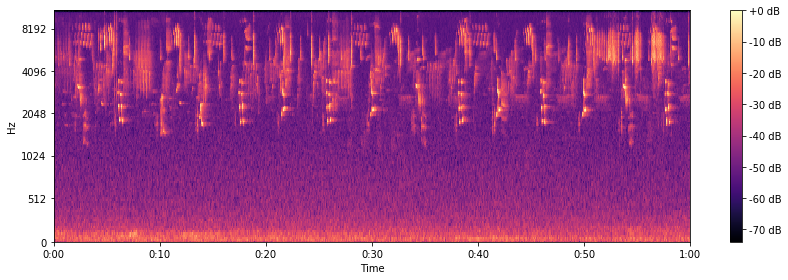

In [27]:
spect = display_mel_spectrogram(samples, sample_rate)

### Helper function to make spectrogram

In [28]:
def make_spectrogram(
    samples,
    sample_rate = 22050, 
    fmax = 10300,
    fmin = 160,
    
    n_mels = 128,
    S = None,
    n_fft = 2048,
    hop_length = 360,
    win_length = 1536,
    window = 'hann',
    center = True,
    power = 2.0,
):
    '''
    Make mel spectrogram in decibels
    
    Create a mel spectrogram in decibels between
    a certain band of frequencies (fmax and fmin).
    
    Args:
        samples (np.array): numpy array of audio samples
        sample_rate (int or float): sample rate of samples
        fmax: maximum frequency to include in spectrogram
        fmin: minimum frequency to include in spectrogram
        other arguments: see the librosa documentation:
            https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html
            https://librosa.github.io/librosa/generated/librosa.filters.mel.html
    
    Returns:
        decibel-formatted spectrogram in the form of an np.array
    '''
    fmax = min(fmax, (sample_rate/2))
    
    spectrogram = librosa.feature.melspectrogram(
        samples, 
        sr = sample_rate, 
        fmax = fmax,
        fmin = fmin,
        S = S,
        n_fft = n_fft,
        hop_length = hop_length,
        win_length = win_length,
        window = window,
        center = center,
        power = power,
        n_mels = n_mels
        
    )
    
    return librosa.power_to_db(spectrogram, ref=np.max)

In [29]:
samples, sample_rate = librosa.load('../tests/veryshort.wav')
spect = make_spectrogram(
    samples,
    sample_rate,
    fmax = 1000,
    fmin = 0)

npt.assert_array_almost_equal(
    spect[0], 
    np.array(
       [ -7.26741 , -12.600594, -44.393555, -28.828209, -26.990265,
       -39.72174 , -33.033913, -29.21325 , -16.667488], dtype=np.float32)
    )

## Remove random high/low spectrogram rows: `remove_random_hi_lo_bands()`

In [30]:
def remove_random_hi_lo_bands(
    spectrogram,
    min_lo = 0,
    max_lo = 10,
    min_hi = 0,
    max_hi = 6,
):
    '''
    Remove random bands at top and bottom of spectrogram
    '''
    # Ensure sensible hi/lo bands
    values = [min_lo, max_lo, min_hi, max_hi]
    for value in values: 
        if value < 0: 
            raise ValueError('Number of bands to remove must be positive')
    if (min_lo > max_lo) or (min_hi > max_hi):
        raise ValueError('Minimum number of bands to remove must be less than or equal to maximum')
    if max_lo + max_hi > spectrogram.shape[0]:
        raise ValueError('Maximum number of bands to remove cannot be greater than number of bands in spectrogram')
    
    hi_remove = random.randint(min_hi, max_hi)
    lo_remove = random.randint(min_lo, max_lo)
    
    # The high-frequency bands are the last bands in the spectrogram
    return spectrogram[lo_remove:-hi_remove]

In [31]:
# Remove the first band and the last two
removed = remove_random_hi_lo_bands(
    np.array([
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]
    ),
    min_lo = 1,
    max_lo = 1,
    min_hi = 2,
    max_hi = 2
)
npt.assert_array_equal(removed, np.array([
    [1, 1, 1, 1],
    [2, 2, 2, 2]]))

# Remove everything!
base_array = np.array([
    [0, 0, 0, 0],
    [3, 3, 3, 3],
    [4, 4, 4, 4]])
empty_array = base_array[0:0]
removed = remove_random_hi_lo_bands(
    base_array,
    min_lo = 1,
    max_lo = 1,
    min_hi = 2,
    max_hi = 2
)
npt.assert_array_equal(removed, empty_array)


# Ensure value checking of min/max bands to remove
# Min should be less than max
with pytest.raises(ValueError):
    test = remove_random_hi_lo_bands(
        np.array([[0, 0, 0, 0]]),
        min_lo = 2,
        max_lo = 1,
    )

# Can't remove negative bands
with pytest.raises(ValueError):
    test = remove_random_hi_lo_bands(
        np.array([[0, 0, 0, 0]]),
        min_hi = -2,
        max_hi = 2
    )

# Can't remove more bands than exist in spectrogram
with pytest.raises(ValueError): 
    test = remove_random_hi_lo_bands(
        np.array([[0, 0, 0, 0]]),
        max_lo = 1,
        max_hi = 1
    )

## Resize random columns: `resize_random_cols()`

In [32]:
np.array([[1, 2], [1, 2], [1, 2]]).shape

(3, 2)

In [33]:
import skimage.transform

def resize_random_bands(
    spectrogram,
    rows_or_cols = 'rows',
    chance_resize = 0.5,
    min_division_size = 10,
    max_division_size = 100,
    min_stretch_factor = 0.9,
    max_stretch_factor = 1.1
):
    '''
    Resize random row or column chunks of spectrogram
    
    With a certain percentage chance, divide 
    spectrogram into random chunks along one axis 
    (row-wise or column-wise chunks) and resize
    each chunk with a randomly chosen scaling factor.
    
    Args:
        spectrogram (np.array): the spectrogram image
        rows_or_cols (string, 'rows' or 'cols'): whether
            to divide spectrogram into chunks by rows 
            (horizontal chunks spanning all times of the
            spectrogram) or columns (vertical chunks
            spanning the whole frequency range of the 
            spectrogram)
        chance_resize (float between 0 and 1): percent
            chance of dividing up the spectrogram and
            performing resizing operations
        min_division_size (int > 0): minimum size in pixels
            for each spectrogram division
        max_division_size (int): maximum size in pixels 
            for each spectrogram division.
        min_stretch_factor (float): minimum scaling factor.
            values < 1 allow spectrogram to shrink
        max_stretch_factor (float): maximum scaling factor.
            values > 1 allow spectrogram to stretch
    
    Returns:
        either the rescaled spectrogram 
            (with probability = chance_resize) or the 
            original spectrogram (prob = 1 - chance_resize)
    '''
    
    
    # Check sensibility of division sizes and stretch factors
    factors = [
        chance_resize,
        min_division_size,
        max_division_size,
        min_stretch_factor,
        max_stretch_factor
    ]
    for factor in factors: 
        if factor < 0: 
            raise ValueError('Division and stretch sizes must be > 0')
    if (min_division_size > max_division_size) or \
        (min_stretch_factor > max_stretch_factor):
            raise ValueError('Minimum division and stretch sizes must be smaller than maximum')
    
    # Probabilistically don't resize
    if random.random() > chance_resize:
        return spectrogram
    
    if rows_or_cols == 'rows':
        axis = 0
    elif rows_or_cols == 'cols':
        axis = 1
    else:
        raise ValueError("Parameter rows_or_cols must be either 'rows' or 'cols'")
    
    len_spectrogram = spectrogram.shape[1]
    len_divisions = 0
    stretched_divisions = []

    # Incrementally divide spectrogram and stretch portions
    while len_divisions < len_spectrogram: 
        # Grab randomly sized portion of spectrogram
        size_division = random.randint(min_division_size, max_division_size)
        division = np.split(
            spectrogram,
            (len_divisions, len_divisions + size_division),
            axis = axis
        )[1]
        
        # Stretch portion of spectrogram
        stretch_factor = random.uniform(min_stretch_factor, max_stretch_factor)
        if rows_or_cols == 'cols': multiplier = (1, stretch_factor)
        else: multiplier = (stretch_factor, 1)
        stretched = skimage.transform.rescale(
            division,
            multiplier,
            preserve_range = True,
            multichannel = False
        )
        stretched_divisions.append(stretched)
       
        len_divisions += size_division
        
    
    # Concatenate all stretched divisions
    return np.concatenate(stretched_divisions, axis = axis)

In [34]:
# Input testing

# Test resizing random columns
test_boi = np.array([
    [0, 1],
    [1, 1],
])
true_2x_stretched = np.array([
    [0, 0, 1, 1],
    [1, 1, 1, 1]])

stretched_2x = np.rint(resize_random_bands(
    spectrogram=test_boi,
    rows_or_cols = 'cols',
    chance_resize = 1,
    min_division_size = 1,
    max_division_size = 1,
    min_stretch_factor = 2,
    max_stretch_factor = 2))

npt.assert_array_equal(stretched_2x, true_2x_stretched)


# Test resizing random rows
test_boi = np.array([
    [0, 0],
    [1, 1],
])
true_2x_stretched = np.array([
    [0, 0],
    [0, 0],
    [1, 1],
    [1, 1]])

stretched_2x = np.rint(resize_random_bands(
    spectrogram=test_boi,
    rows_or_cols = 'rows',
    chance_resize = 1,
    min_division_size = 1,
    max_division_size = 1,
    min_stretch_factor = 2,
    max_stretch_factor = 2))

npt.assert_array_equal(stretched_2x, true_2x_stretched)